In [1]:
%run load_data.ipynb
print (dir())

['DataFrame', 'In', 'Math', 'Out', 'SIZE_RATIO_CUT', 'SNR_CUT', 'Series', 'T_CUT', 'Table', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_ih', '_ii', '_iii', '_oh', 'bottleneck', 'display', 'exit', 'filter_by_snr', 'fits', 'get_df_list', 'get_ipython', 'h5py', 'i', 'index_2_3', 'index_2_3_true', 'index_2_3_true_negative', 'index_2_3_true_positive', 'index_4_5', 'index_4_5_true', 'index_4_5_true_negative', 'index_4_5_true_positive', 'load_mcal', 'load_true', 'mcal_df_list', 'mcal_df_list_negative', 'mcal_df_list_positive', 'np', 'numexpr', 'pd', 'photdf', 'plt', 'quit', 'tqdm', 'true_df_list']


In [2]:
import healpy as hp
import astropy_healpix as a_hp

# Choose NSIDE

In [3]:
NSIDE=256 #or 512
NPIX=hp.nside2npix(NSIDE)
print ("The number of pixels is: {}.".format(NPIX))
G_INDEX=np.arange(NPIX)

The number of pixels is: 786432.


In [4]:
final_df_list=[None]*4
for i,catalog in enumerate(mcal_df_list_positive):
    final_df_list[i]=pd.concat([catalog,photdf[['true_cm_g_1','true_cm_g_2']]],axis=1,join='inner')

In [16]:
def get_healpix(df):
    print ("The length of the df is: {}.".format(len(df)))
    print ("The ratio of the length of the catagory to the total pixel number is: {:.2%}".format(len(df)/NPIX))
    df['ipix']=df.apply(lambda x:hp.ang2pix(NSIDE,np.pi/2-np.deg2rad(x['dec']),np.deg2rad(x['ra']),nest=True),axis=1)
    print("The propotion of rendered objects is: {:.2%}".format(np.sum(df['ipix']!=0)/len(df)))
    print ("Resetting indexes")
    df_ipix=df.set_index('ipix')
    df_ipix_sorted=df_ipix.sort_index()
    return (df_ipix_sorted)

def group_ipix(df_ipix_sorted):
    number_mask=df_ipix_sorted.groupby('ipix').count()['R11']<10
    df_sorted_grouped=df_ipix_sorted.groupby('ipix').mean()
    df_sorted_grouped_masked=df_sorted_grouped[number_mask]
    print ("The mean of R11 is {}, max is {}, min is {}".format(df_sorted_grouped_masked['R11'].mean(),df_sorted_grouped_masked['R11'].max(),df_sorted_grouped_masked['R11'].min()))
    print ("The mean of R22 is {}, max is {}, min is {}".format(df_sorted_grouped_masked['R22'].mean(),df_sorted_grouped_masked['R22'].max(),df_sorted_grouped_masked['R22'].min()))
    R11 = df_sorted_grouped_masked['R11'].mean()
    R22 = df_sorted_grouped_masked['R22'].mean()
    df_sorted_grouped_masked['delta_g1']=df_sorted_grouped_masked.apply(lambda x:x['e_1']/R11-x['true_cm_g_1'],axis=1)
    df_sorted_grouped_masked['delta_g2']=df_sorted_grouped_masked.apply(lambda x:x['e_2']/R22-x['true_cm_g_2'],axis=1)
#     print ("The propotion of averaged objects is: {:.2%}".format((len(df_ipix_sorted)-len(df_sorted_grouped_masked))/len(df_ipix_sorted)))
    print ("---------------------------------")
    return (df_sorted_grouped_masked)

In [13]:
ipix_sorted = [get_healpix(df) for df in final_df_list]

The length of the df is: 272818.
The ratio of the length of the catagory to the total pixel number is: 34.69%
The propotion of rendered objects is: 100.00%
Resetting indexes
The length of the df is: 272818.
The ratio of the length of the catagory to the total pixel number is: 34.69%
The propotion of rendered objects is: 100.00%
Resetting indexes
The length of the df is: 215145.
The ratio of the length of the catagory to the total pixel number is: 27.36%
The propotion of rendered objects is: 100.00%
Resetting indexes
The length of the df is: 215145.
The ratio of the length of the catagory to the total pixel number is: 27.36%
The propotion of rendered objects is: 100.00%
Resetting indexes


In [17]:
ipix_sorted_filtered_grouped=[group_ipix(df) for df in ipix_sorted]

The mean of R11 is 0.78644835142623, max is 13.67369349540634, min is -6.992034474310287
The mean of R22 is 0.7855622549926757, max is 10.63652140008755, min is -12.231064460480107


/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


---------------------------------
The mean of R11 is 0.7750157162403251, max is 17.03993360179426, min is -6.842691657484413
The mean of R22 is 0.7847042804545312, max is 21.176713510351416, min is -32.04549961794578
---------------------------------
The mean of R11 is 0.7722151369321218, max is 7.48179347176924, min is -26.84834620190807
The mean of R22 is 0.81033143757935, max is 17.67501272412899, min is -10.426019279742748
---------------------------------
The mean of R11 is 0.7722151369321218, max is 7.48179347176924, min is -26.84834620190807
The mean of R22 is 0.81033143757935, max is 17.67501272412899, min is -10.426019279742748
---------------------------------


In [38]:
def fill_for_plot(df,key_array):
    df_filled=df[key_array].reindex(index=G_INDEX,fill_value=np.nan)
    print("The propotion of filled pixels is: {}.".format(np.sum(df_filled['delta_g1']>0)/NPIX))
    return(df_filled)

In [37]:
hp_filled_list=[fill_for_plot(df,['delta_g1','delta_g2']) for df in ipix_sorted_filtered_grouped]

The propotion of filled pixels is: 0.002887725830078125.
The propotion of filled pixels is: 0.0029856363932291665.
The propotion of filled pixels is: 0.003734588623046875.
The propotion of filled pixels is: 0.003734588623046875.


/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/healpy/projaxes.py:1176: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/healpy/projaxes.py:11

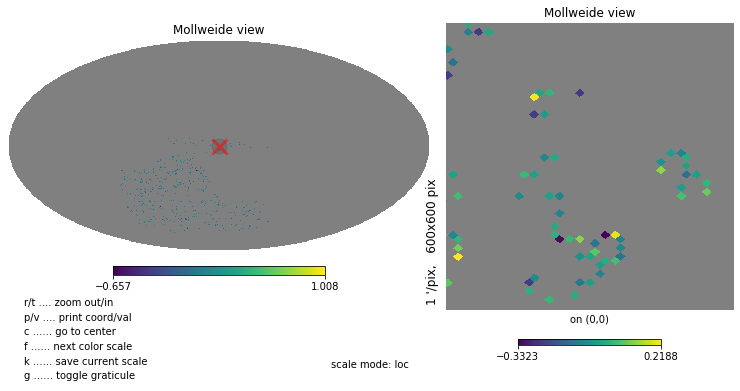

In [20]:
hp.mollzoom(hp_filled_list[0]['delta_g1'].to_numpy(),nest=True)

# Compare maps

In [21]:
maps=h5py.File('/home/cz136/Y3_GOLD_2_2_1_maps.h5','r')['maps'] #no neighbor

In [22]:
for key in maps.keys():
    print ("{:20} has {} objects".format(key,len(maps[key])))

det_frac             has 25169981 objects
ebv_planck13         has 25169981 objects
g                    has 7 objects
hpix                 has 25169981 objects
i                    has 7 objects
r                    has 7 objects
star_density_piffv23 has 25169981 objects
z                    has 7 objects


In [23]:
ipix_maps={}
GOLD_INDEX=np.arange(hp.nside2npix(4096))
for key in ['ebv_planck13','star_density_piffv23','det_frac']:
    hpix=np.full(hp.nside2npix(4096),np.nan)
    hpix[maps['hpix']]=maps[key]
    ipix_maps[key]=np.array(hpix)

In [24]:
gold_df=pd.DataFrame(data=ipix_maps,index=GOLD_INDEX)

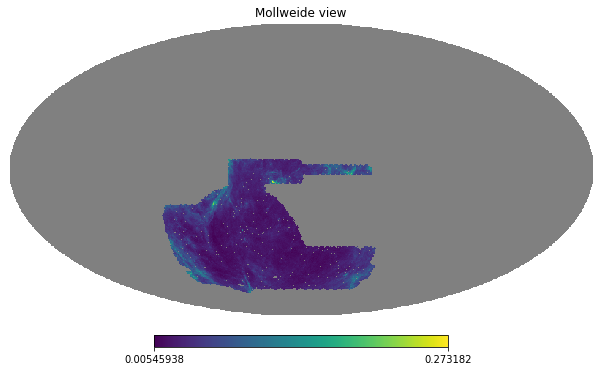

In [25]:
hp.mollview(gold_df['ebv_planck13'].to_numpy(),nest=True)

In [26]:
downgraded_maps={}
for key,value in ipix_maps.items():
    downgraded_maps[key]=hp.pixelfunc.ud_grade(value, NSIDE, order_in='NESTED', order_out='NESTED')

In [27]:
gold_df_downgraded=pd.DataFrame(data=downgraded_maps,index=G_INDEX)

In [28]:
gold_join_delta_g_list=[None]*4
for i,catalog in enumerate(ipix_sorted_filtered_grouped):
        gold_join_delta_g_list[i]=pd.concat([catalog,gold_df_downgraded],axis=1,join='inner')
        gold_join_delta_g_list[i].index.name="ipix"

In [39]:
gng_filled_list=[fill_for_plot(df,['delta_g1','delta_g2','ebv_planck13','star_density_piffv23','det_frac']) for df in gold_join_delta_g_list]

The propotion of filled pixels is: 0.002887725830078125.
The propotion of filled pixels is: 0.0029856363932291665.
The propotion of filled pixels is: 0.003734588623046875.
The propotion of filled pixels is: 0.003734588623046875.


/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/healpy/projaxes.py:1176: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/healpy/projaxes.py:11

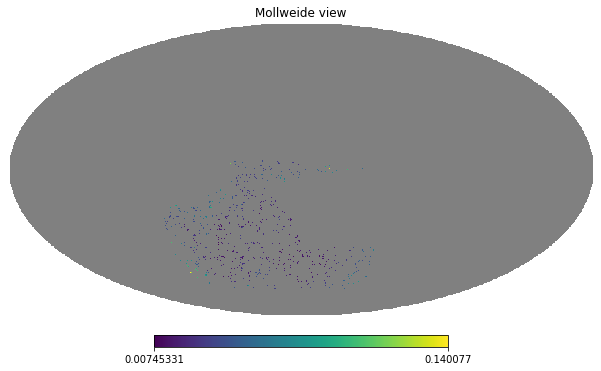

In [40]:
hp.mollview(gng_filled_list[1]['ebv_planck13'].to_numpy(),nest=True)